## Hurdat2 Get Started
In the following example we will walk through how we can leverage the `clouddrift` library to do something interesting with the HURDAT2 dataset. Simply put, the HURDAT2 dataset is a dataset that contains storm track data (including other measurements such as pressure, wind speed, etc...) for storms recorded from 1852 - 2022 across both the Pacific and Atlantic Ocean.

First were going to setup some utility functions that will help us work with Ragged Arrays

In [1]:
from clouddrift.ragged import subset
from clouddrift.raggedarray import DimNames, RaggedArray


def sel(self: RaggedArray, criteria: dict) -> RaggedArray:
    dimToAlias: dict[DimNames, str] = {self.name_dims[k]: k for k in self.name_dims}
    return RaggedArray.from_xarray(
        subset(
            self.to_xarray(),
            criteria,
            row_dim_name=dimToAlias["rows"],
            obs_dim_name=dimToAlias["obs"]
        ),
        rows_dim_name=dimToAlias["rows"],
        obs_dim_name=dimToAlias["obs"]
    )

def iter(self: RaggedArray):
    dimToAlias = {self.name_dims[k]: k for k in self.name_dims}
    dimToCoord = {self._coord_dims[k]: k for k in self._coord_dims}

    rowAlias = dimToAlias["rows"]
    rowCoord = dimToCoord[rowAlias]

    for row in self.coords[rowCoord]:
        yield sel(self, {rowCoord: row})

Then were going to proceed with loading in the datasets were interested in taking a look at.

In [2]:
from clouddrift import datasets


# Lets load the hurdat2 storm track data.
storm_ds = datasets.hurdat2(decode_times=True)
storm_ra = RaggedArray.from_xarray(storm_ds, rows_dim_name="traj")

/home/ksantana/.clouddrift/data/hurdat2_both.nc not found; download from upstream repository.


https://www.aoml.noaa.gov/hrd/hurdat/hurdat2-nepac.html: 3.25MB [00:00, 6.06MB/s]
https://www.aoml.noaa.gov/hrd/hurdat/hurdat2-nepac.html: 3.72MB [00:00, 5.77MB/s]
https://www.aoml.noaa.gov/hrd/hurdat/hurdat2.html: 6.61MB [00:00, 7.72MB/s]
Filling the Ragged Array: 100%|███████████| 3143/3143 [00:02<00:00, 1441.57it/s]


Lets load the drifter dataset. The cell below is only executed if `drifter_ds` is undefined (in other words its the first time your running the notebook) or set the `force` variable to `True`

In [4]:
import clouddrift
import os

fp = "aggregate_gdp6h_local.nc"
force = False
n_random_id = 10_000

try:
    drifter_ds
except NameError:
    if not os.path.exists(fp):
        drifter_ds = clouddrift.adapters.gdp6h.to_raggedarray(n_random_id=n_random_id).to_netcdf(fp)
else:
    if force:
        drifter_ds = clouddrift.adapters.gdp6h.to_raggedarray(n_random_id=n_random_id).to_netcdf(fp)

Retrieving the number of obs: 100%|██████| 10000/10000 [01:16<00:00, 130.15it/s]
/home/ksantana/miniconda3/envs/hurdat2-get-started/lib/python3.10/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'WMO' has multiple fill values {-999999, '-999999'} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
Filling the Ragged Array: 100%|███████████| 10000/10000 [07:26<00:00, 22.39it/s]


In [5]:
import xarray as xr

# Letsl also load the drifter track data.
drifter_ds = xr.load_dataset(fp)
drifter_ra = RaggedArray.from_xarray(drifter_ds, rows_dim_name="traj")

Now lets say that we'd like to select a specific subset of this dataset; we can leverage the `subset` utility function provided through the `ragged` module which contains a library of helpful utility functions for working with the `RaggedArray` data structure.

As an example say you wanted a subset of the dataset for storms whose track lied within the Atlantic Ocean and was tracked between August and October of 2020. You can leverage the `subset` function to help you achieve this by first defining the criteria:

In [6]:
# import some helpful libraries
import numpy as np
from datetime import datetime

# Here the datasets variables are mapped to an (inclusive start and end) range
start_dt, end_dt = datetime(2020, 8, 1), datetime(2020, 10, 1)
criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        np.datetime64(int(start_dt.timestamp()), "s"),
        np.datetime64(int(end_dt.timestamp()), "s")
    )
)

Lets import the `subset` function and apply the criteria to both datasets. 

Here we need to provide the row dimensions alias which is `traj` in both datasets.

In [7]:
matching_storms = sel(storm_ra, criteria)

In [8]:
matching_drifters = sel(drifter_ra, criteria)

Text(0.5, 1.0, 'Hurricane Season 2020')

/home/ksantana/miniconda3/envs/hurdat2-get-started/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


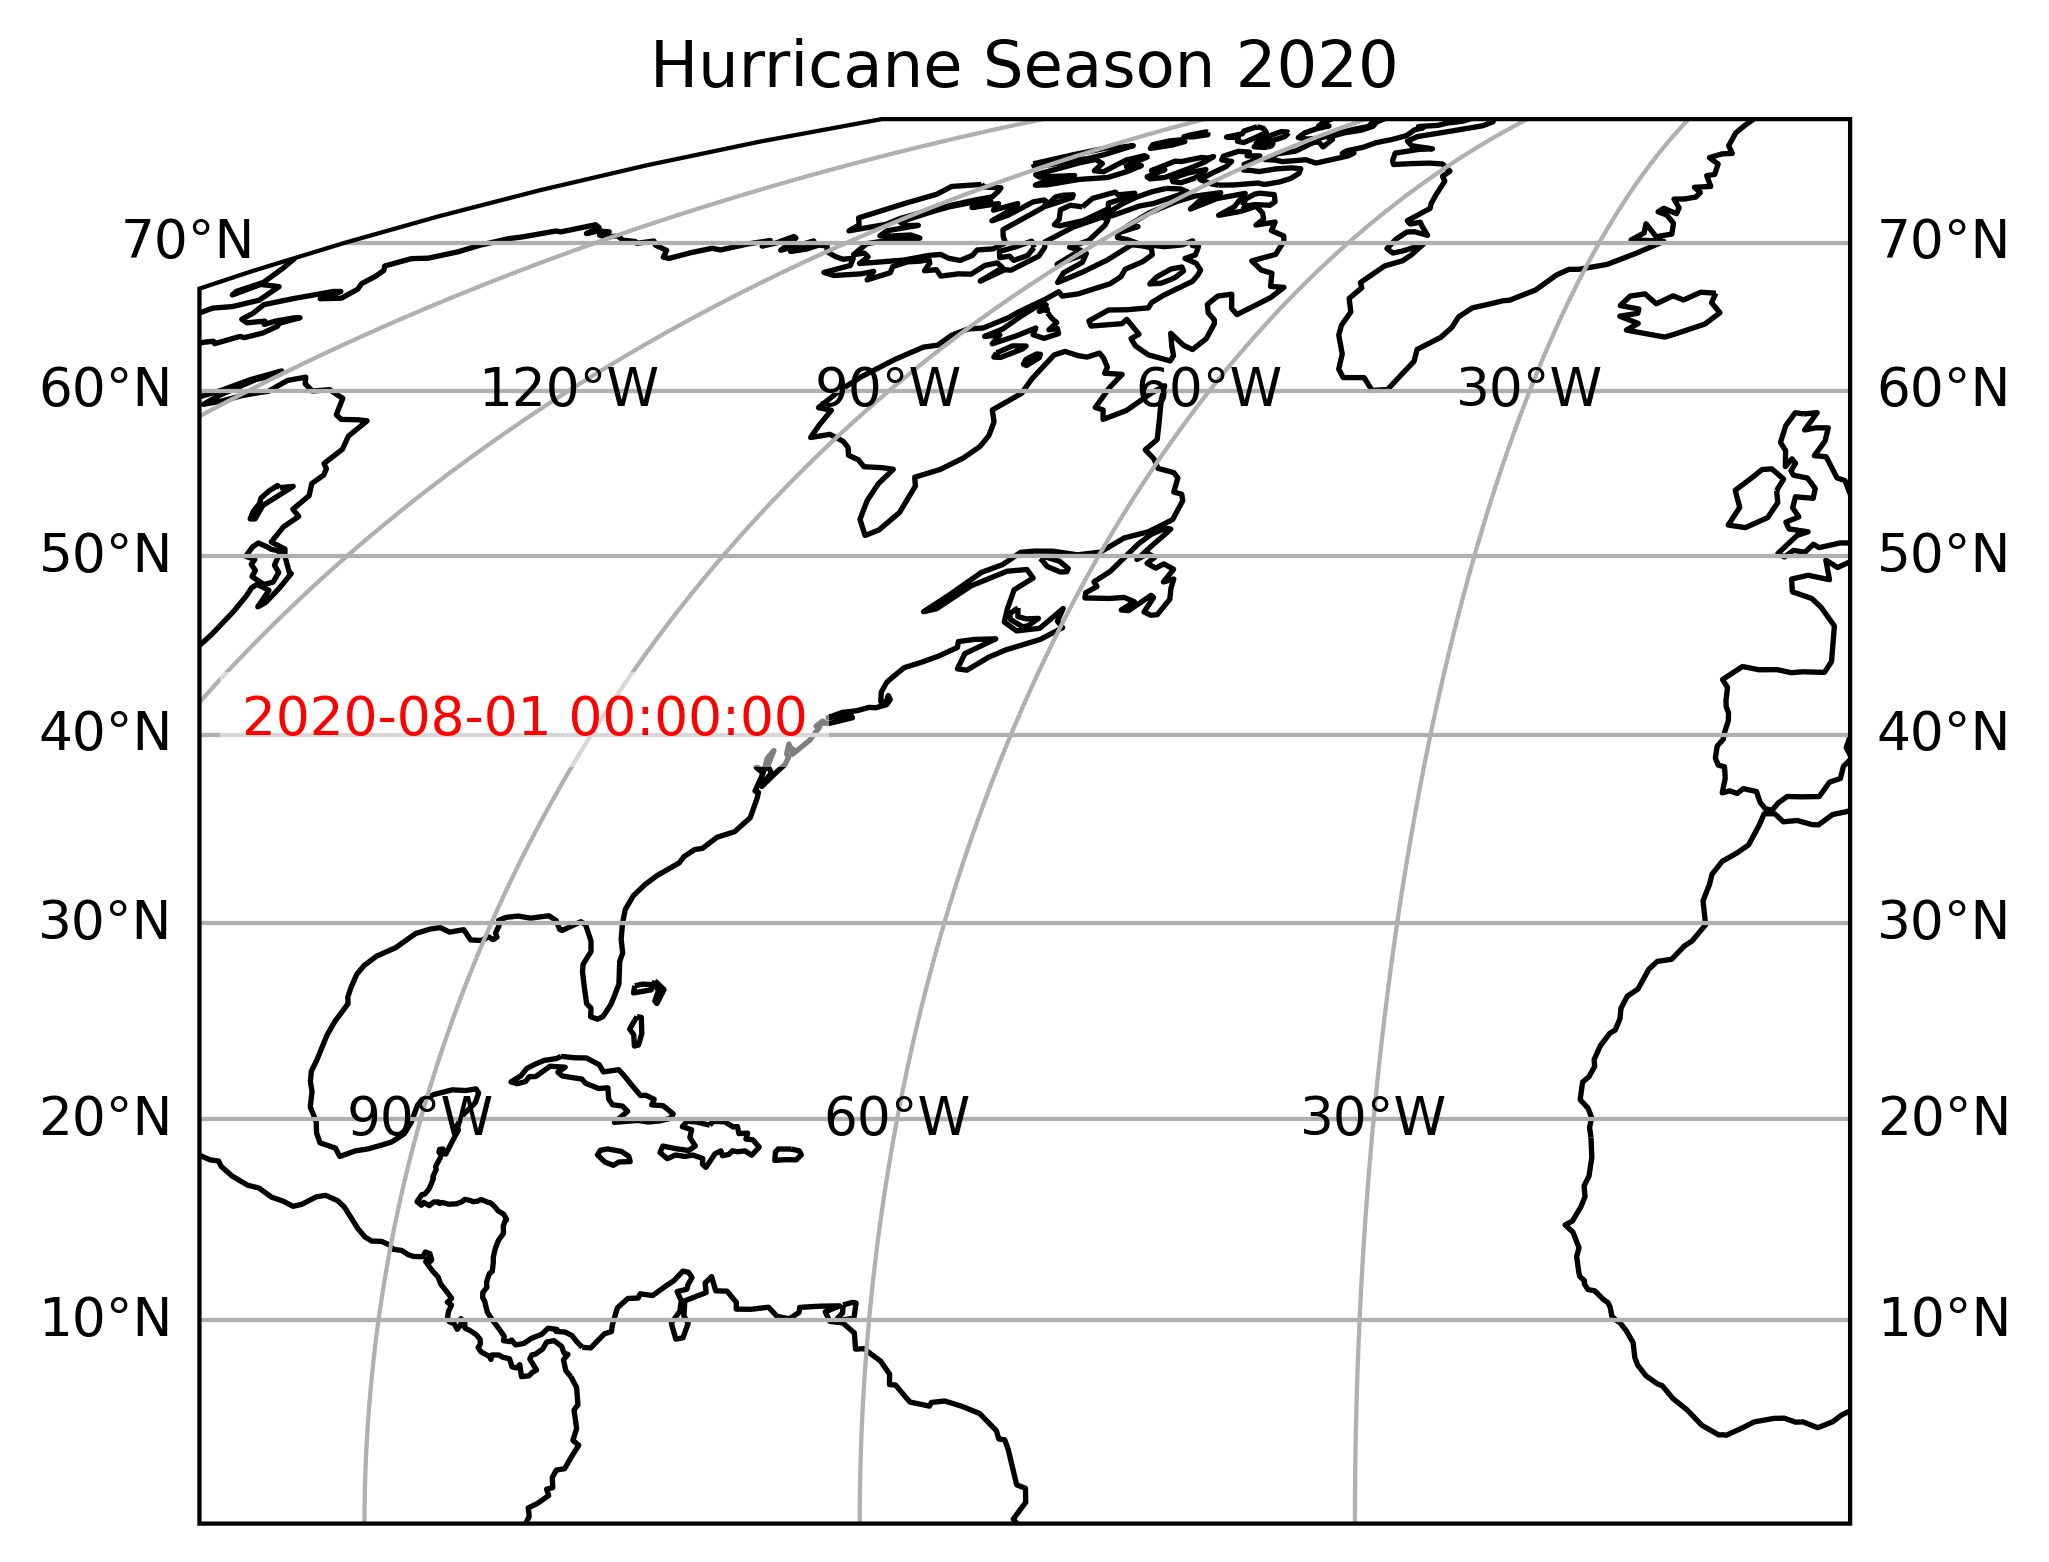

In [9]:
import cartopy.crs as ccrs  # cartopy for projecting our dataset onto different map projections
import matplotlib.pyplot as plt # is an standard plotting library
import matplotlib.animation as animation


DPI = 384
fig = plt.figure(figsize=(7.75, 4.75), dpi=DPI)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
ax.set_extent([-100, 0, 0, 80], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
datetime_label = ax.text(-115, 40, start_dt.strftime('%Y-%m-%d %H:%M:%S'), 
    fontsize=10, 
    color="red", 
    transform=ccrs.PlateCarree(), 
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
)
ax.set_title("Hurricane Season 2020")

Were going to iterate over both, the selected storms and the selected drifters. For each of the trajectories, we plot their starting point and store some data to be utilized for generating the animation.

In [10]:
storm_lines = list()
drifter_lines = list()

for storm in iter(matching_storms):
    storm = storm.to_xarray()
    selected_lon, selected_lat = storm["lon"], storm["lat"]
    selected_lon, selected_lat = selected_lon.set_xindex("time"), selected_lat.set_xindex("time")
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=3,
        transform=ccrs.PlateCarree(),
    )
    storm_lines.append((selected_lon, selected_lat, line[0]))

for drifter in iter(matching_drifters):
    drifter = drifter.to_xarray()
    selected_lon, selected_lat, selected_temp = drifter["lon"], drifter["lat"], drifter["temp"]
    selected_lon, selected_lat, selected_temp = (selected_lon.set_xindex("time"), selected_lat.set_xindex("time"), selected_temp.set_xindex("time"))
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=1,
        transform=ccrs.PlateCarree(),
    )
    drifter_lines.append((selected_lon, selected_lat, selected_temp, line[0]))


Lets take the start and end date we've used for the criteria and generate an range of values that each map uniquely to a frame.

/tmp/ipykernel_12022/74340040.py:7: RuntimeWarning: All-NaN axis encountered
  min_t = np.nanmin([np.nanmin(temp) for (_, _, temp, _) in drifter_lines])
/tmp/ipykernel_12022/74340040.py:8: RuntimeWarning: All-NaN axis encountered
  max_t = np.nanmax([np.nanmax(temp) for (_, _, temp, _) in drifter_lines])


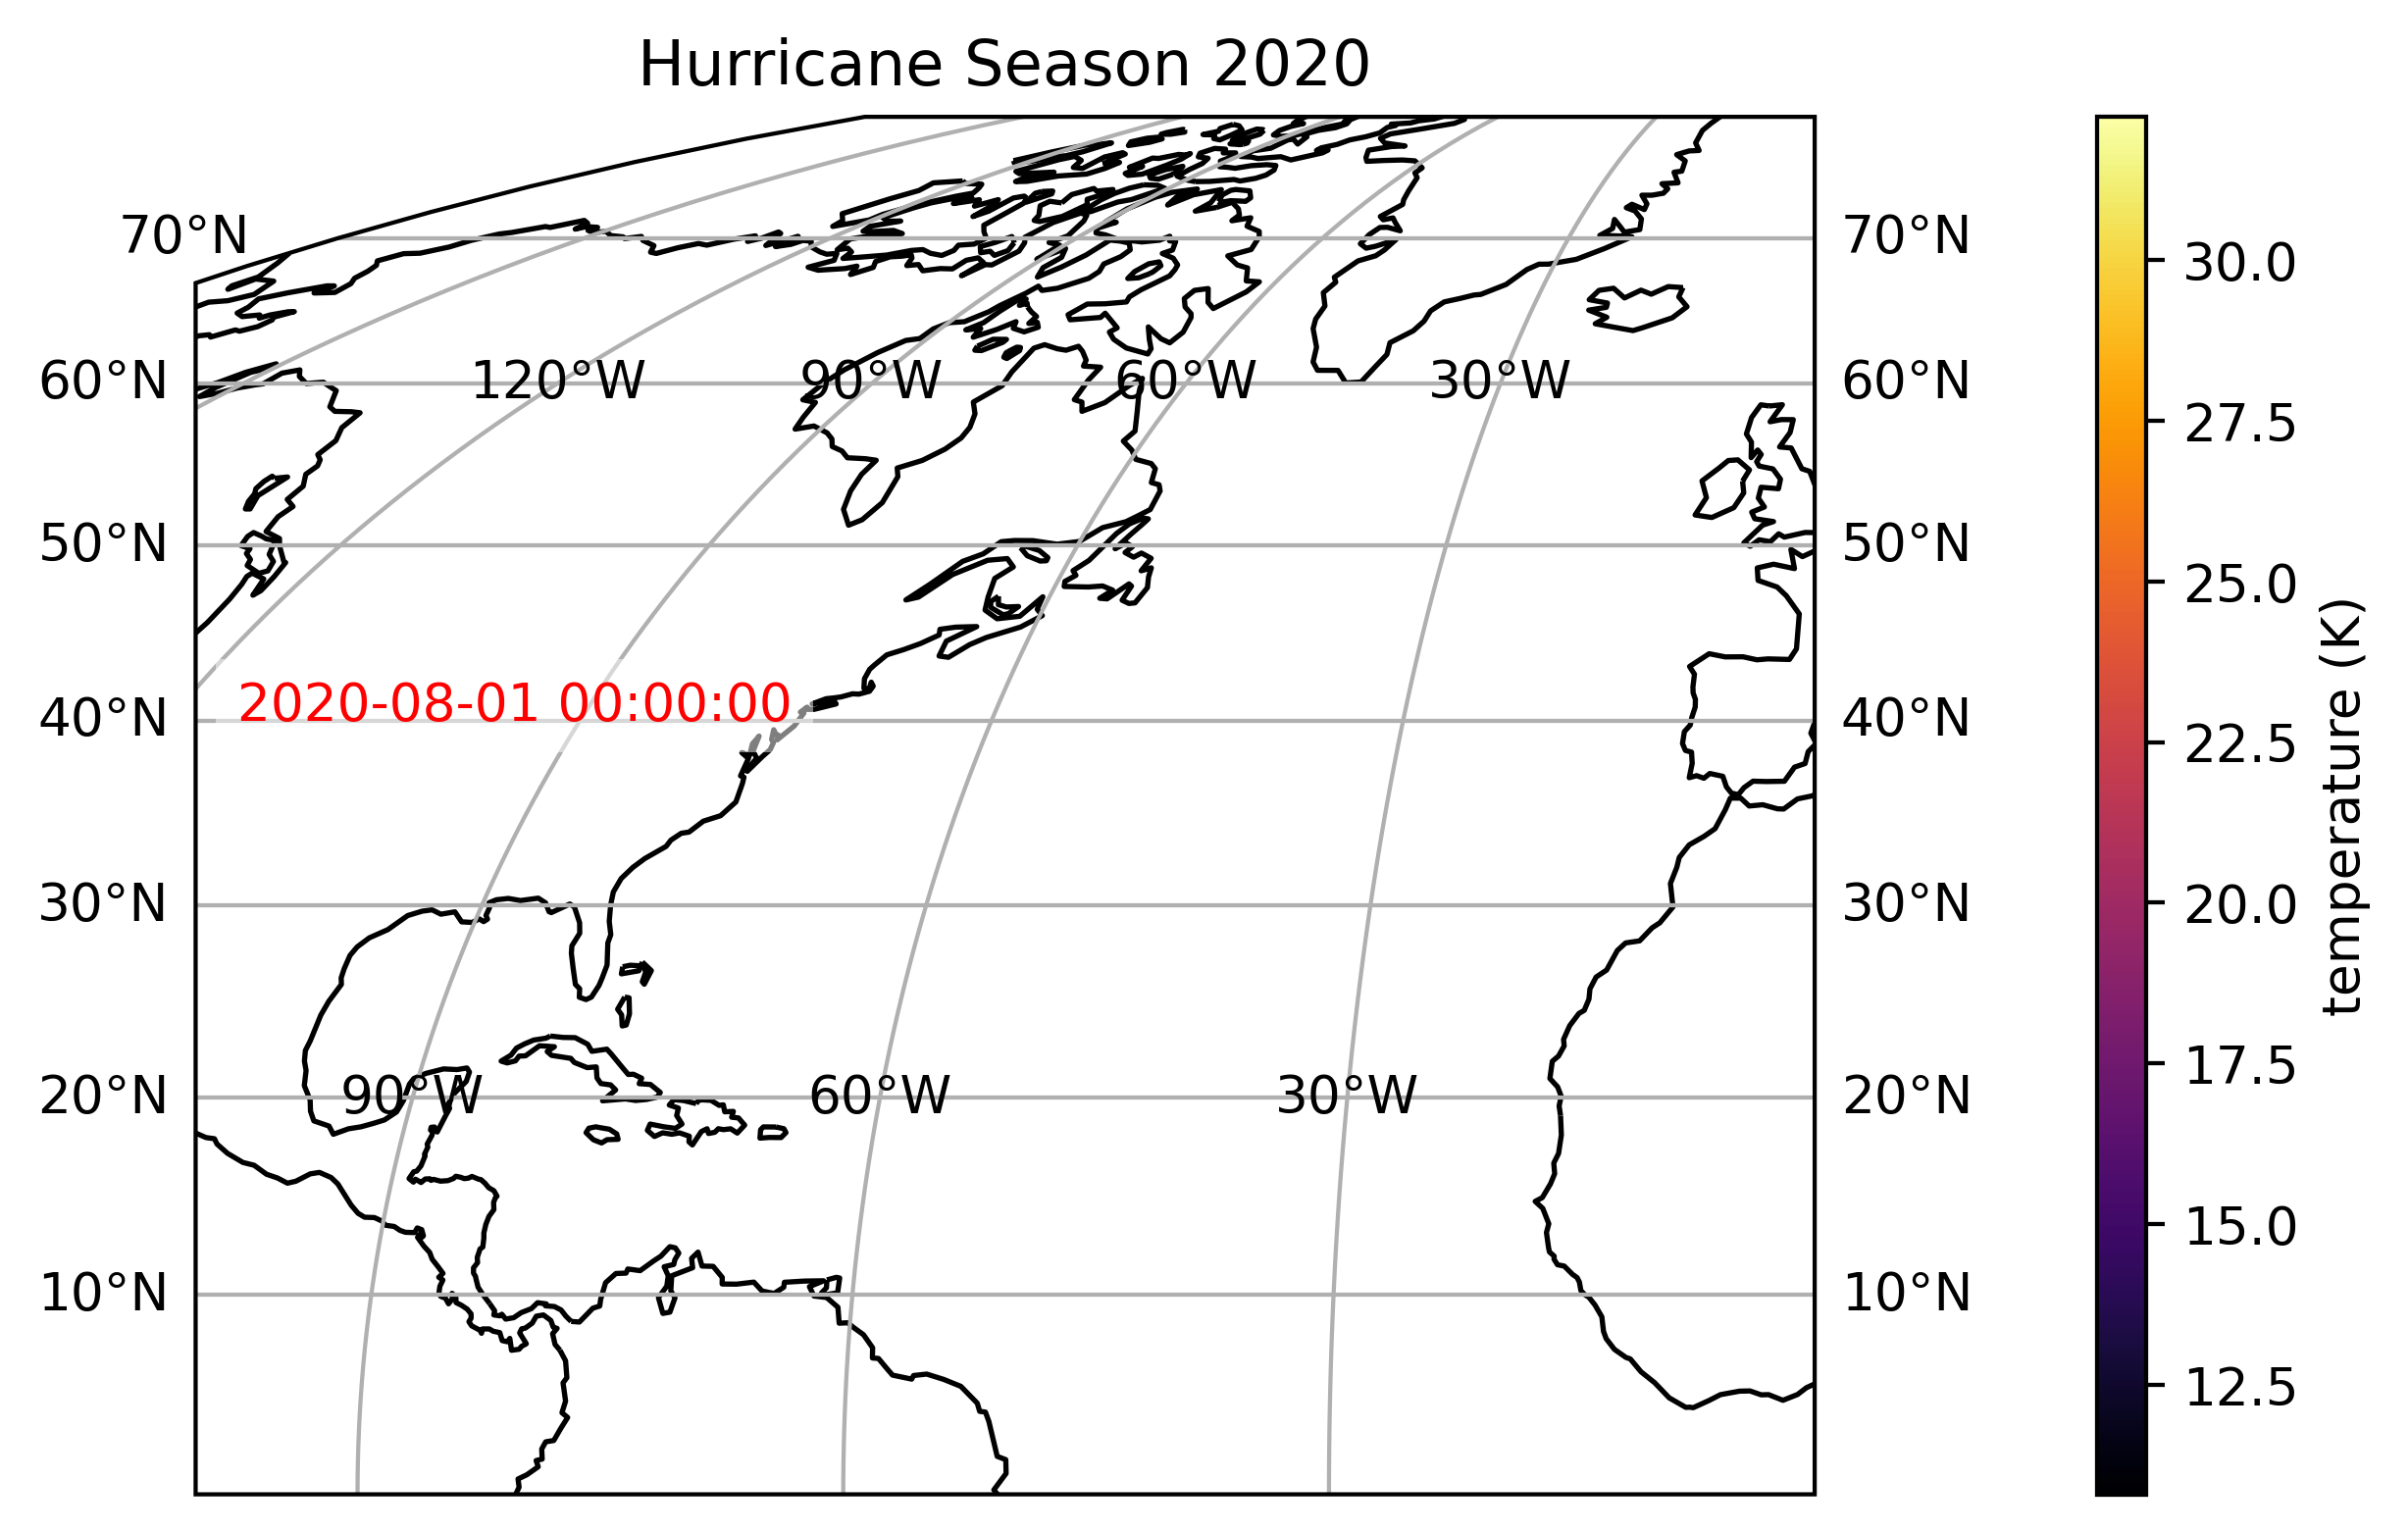

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = plt.get_cmap("inferno")
min_t = np.nanmin([np.nanmin(temp) for (_, _, temp, _) in drifter_lines])
max_t = np.nanmax([np.nanmax(temp) for (_, _, temp, _) in drifter_lines])
(min_t, max_t)
norm = colors.Normalize(vmin=min_t, vmax=max_t)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.75, axes_class=plt.Axes)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label="temperature (K)")
fig

In [12]:
import matplotlib.colors as mcolors

def _normalize(x):
    return (x - min_t) / (max_t - min_t)

def _get_temp_color(x):
    norm_val = _normalize(x)
    rgba = cmap(norm_val)
    return mcolors.to_hex(rgba)

In [13]:
import pandas as pd
frame_count = 500
daterange = pd.date_range(start_dt, end_dt, frame_count)

Lets now generate each frame by selecting the date associated to it which we utilize to update each trajectory with new observations

In [14]:
storm_frames = list()
drifter_frames = list()
frames = dict()
tail_len = 20

for idx, dt in enumerate(daterange):
    if (idx % 100 == 0):
        print(f"generating index: {idx}")
    storm_updates = list()

    for s_lon, s_lat, s_line in storm_lines:
        sel_d_lon = s_lon.sel(time=slice(start_dt, dt))
        sel_d_lat = s_lat.sel(time=slice(start_dt, dt))
        storm_updates.append((sel_d_lon, sel_d_lat, s_line))

    drifter_updates = list()
    for d_lon, d_lat, d_temp, d_line, in drifter_lines:
        sel_d_lon = d_lon.sel(time=slice(start_dt, dt))
        sel_d_lat = d_lat.sel(time=slice(start_dt, dt))
        sel_d_temp = d_temp.sel(time=slice(start_dt, dt))
        sel_d_lon = sel_d_lon.tail(obs=tail_len)
        sel_d_lat = sel_d_lat.tail(obs=tail_len)
        sel_d_temp = sel_d_temp.tail(obs=tail_len)
        drifter_updates.append((sel_d_lon, sel_d_lat, sel_d_temp, d_line))

    frames[dt] = dict(drifter_updates=drifter_updates, storm_updates=storm_updates)

generating index: 0
generating index: 100
generating index: 200
generating index: 300
generating index: 400


We define an update function that, using the frame index, selects the frame and updates each trajectories longitude and latitude

In [15]:

sorted_dates = sorted(frames.keys())

def update(frame_idx):
    frame_dt = sorted_dates[frame_idx]
    frame = frames[frame_dt]
    drifter_updates = frame["drifter_updates"]
    storm_updates = frame["storm_updates"]

    datetime_label.set_text(frame_dt.strftime('%Y-%m-%d %H:%M:%S'))

    updated_lines = list()
    for x_update, y_update, line in storm_updates:
        line.set_xdata(x_update)
        line.set_ydata(y_update)
        updated_lines.append(line)

    for x_update, y_update, temps, line in drifter_updates:
        line.set_xdata(x_update)
        line.set_ydata(y_update)
        if len(temps) > 0:
            line.set_color(_get_temp_color(np.nanmean(temps)))
        updated_lines.append(line)
    return updated_lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=frame_count, interval=50)

In [16]:
ani.save("storm_drifters.gif", dpi=DPI, progress_callback=lambda i, n: print(f'Saving frame {i}/{n}'))

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving frame 0/500
Saving frame 1/500
Saving frame 2/500
Saving frame 3/500
Saving frame 4/500
Saving frame 5/500
Saving frame 6/500
Saving frame 7/500
Saving frame 8/500
Saving frame 9/500
Saving frame 10/500
Saving frame 11/500
Saving frame 12/500
Saving frame 13/500
Saving frame 14/500
Saving frame 15/500
Saving frame 16/500
Saving frame 17/500
Saving frame 18/500
Saving frame 19/500
Saving frame 20/500
Saving frame 21/500
Saving frame 22/500
Saving frame 23/500
Saving frame 24/500
Saving frame 25/500
Saving frame 26/500
Saving frame 27/500
Saving frame 28/500
Saving frame 29/500
Saving frame 30/500
Saving frame 31/500
Saving frame 32/500
Saving frame 33/500
Saving frame 34/500
Saving frame 35/500
Saving frame 36/500
Saving frame 37/500
Saving frame 38/500
Saving frame 39/500
Saving frame 40/500
Saving frame 41/500
Saving frame 42/500
Saving frame 43/500
Saving frame 44/500
Saving frame 45/500
Saving frame 46/500
Saving frame 47/500
Saving frame 48/500
Saving frame 49/500
Saving fra

/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 71/500
Saving frame 72/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 73/500
Saving frame 74/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 75/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 76/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 77/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 78/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 79/500
Saving frame 80/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 81/500
Saving frame 82/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 83/500
Saving frame 84/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 85/500
Saving frame 86/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 87/500
Saving frame 88/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 89/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 90/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 91/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 92/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 93/500
Saving frame 94/500
Saving frame 95/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 96/500
Saving frame 97/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 98/500
Saving frame 99/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 100/500
Saving frame 101/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 102/500
Saving frame 103/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 104/500
Saving frame 105/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 106/500
Saving frame 107/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 108/500
Saving frame 109/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 110/500
Saving frame 111/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 112/500
Saving frame 113/500
Saving frame 114/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 115/500
Saving frame 116/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 117/500
Saving frame 118/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 119/500
Saving frame 120/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 121/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 122/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 123/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 124/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 125/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 126/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 127/500
Saving frame 128/500
Saving frame 129/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 130/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 131/500
Saving frame 132/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 133/500
Saving frame 134/500
Saving frame 135/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 136/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 137/500
Saving frame 138/500
Saving frame 139/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 140/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 141/500
Saving frame 142/500
Saving frame 143/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 144/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 145/500
Saving frame 146/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 147/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 148/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 149/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 150/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 151/500
Saving frame 152/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 153/500
Saving frame 154/500
Saving frame 155/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 156/500
Saving frame 157/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 158/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 159/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 160/500
Saving frame 161/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 162/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 163/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 164/500
Saving frame 165/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 166/500
Saving frame 167/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 168/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 169/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 170/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 171/500
Saving frame 172/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 173/500
Saving frame 174/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 175/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 176/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 177/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 178/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 179/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 180/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 181/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 182/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 183/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 184/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 185/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 186/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 187/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 188/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 189/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 190/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 191/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 192/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 193/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 194/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 195/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 196/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 197/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 198/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 199/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 200/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 201/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 202/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 203/500
Saving frame 204/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 205/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 206/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 207/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 208/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 209/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 210/500
Saving frame 211/500
Saving frame 212/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 213/500
Saving frame 214/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 215/500
Saving frame 216/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 217/500
Saving frame 218/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 219/500
Saving frame 220/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 221/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 222/500
Saving frame 223/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 224/500
Saving frame 225/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 226/500
Saving frame 227/500
Saving frame 228/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 229/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 230/500
Saving frame 231/500
Saving frame 232/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 233/500
Saving frame 234/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 235/500
Saving frame 236/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 237/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 238/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 239/500
Saving frame 240/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 241/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 242/500
Saving frame 243/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 244/500
Saving frame 245/500
Saving frame 246/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 247/500
Saving frame 248/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 249/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 250/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 251/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 252/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 253/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 254/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 255/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 256/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 257/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 258/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 259/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 260/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 261/500
Saving frame 262/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 263/500
Saving frame 264/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 265/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 266/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 267/500
Saving frame 268/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 269/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 270/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 271/500
Saving frame 272/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 273/500
Saving frame 274/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 275/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 276/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 277/500
Saving frame 278/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 279/500
Saving frame 280/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 281/500
Saving frame 282/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 283/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 284/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 285/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 286/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 287/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 288/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 289/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 290/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 291/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 292/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 293/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 294/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 295/500
Saving frame 296/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 297/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 298/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 299/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 300/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 301/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 302/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 303/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 304/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 305/500
Saving frame 306/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 307/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 308/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 309/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 310/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 311/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 312/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 313/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 314/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 315/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 316/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 317/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 318/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 319/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 320/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 321/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 322/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 323/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 324/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 325/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 326/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 327/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 328/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 329/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 330/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 331/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 332/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 333/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 334/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 335/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 336/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 337/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 338/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 339/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 340/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 341/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 342/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 343/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 344/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 345/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 346/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 347/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 348/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 349/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 350/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 351/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 352/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 353/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 354/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 355/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 356/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 357/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 358/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 359/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 360/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 361/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 362/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 363/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 364/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 365/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 366/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 367/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 368/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 369/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 370/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 371/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 372/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 373/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 374/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 375/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 376/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 377/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 378/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 379/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 380/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 381/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 382/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 383/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 384/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 385/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 386/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 387/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 388/500
Saving frame 389/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 390/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 391/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 392/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 393/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 394/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 395/500
Saving frame 396/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 397/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 398/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 399/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 400/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 401/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 402/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 403/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 404/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 405/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 406/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 407/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 408/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 409/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 410/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 411/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 412/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 413/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 414/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 415/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 416/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 417/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 418/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 419/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 420/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 421/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 422/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 423/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 424/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 425/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 426/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 427/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 428/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 429/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 430/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 431/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 432/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 433/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 434/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 435/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 436/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 437/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 438/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 439/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 440/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 441/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 442/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 443/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 444/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 445/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 446/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 447/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 448/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 449/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 450/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 451/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 452/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 453/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 454/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 455/500
Saving frame 456/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 457/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 458/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 459/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 460/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 461/500
Saving frame 462/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))
/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 463/500
Saving frame 464/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 465/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 466/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 467/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 468/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 469/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 470/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 471/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 472/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 473/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 474/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 475/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 476/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 477/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 478/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 479/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 480/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 481/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 482/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 483/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 484/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 485/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 486/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 487/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 488/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 489/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 490/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 491/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 492/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 493/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 494/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 495/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 496/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 497/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 498/500


/tmp/ipykernel_12022/3261116377.py:21: RuntimeWarning: Mean of empty slice
  line.set_color(_get_temp_color(np.nanmean(temps)))


Saving frame 499/500
